In [1]:
import numpy as np
import imageio.v3 as iio
import skimage as ski
import matplotlib.pyplot as plt

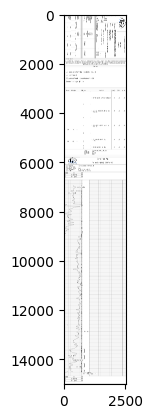

In [61]:
# Load the whole image
O = iio.imread(uri="T14502Las/T14502_02-Feb-07_JewelryLog.tiff")
# Convert to grayscale
#O = ski.color.rgb2gray(O)
def grayscale(colors):
    """Return grayscale of given color."""
    r, g, b = colors
    return 0.21 * r + 0.72 * g + 0.07 * b

result = np.apply_along_axis(grayscale, 2, O)
# Display the image
plt.imshow(O)
plt.show()


y: 15012, x: 2550


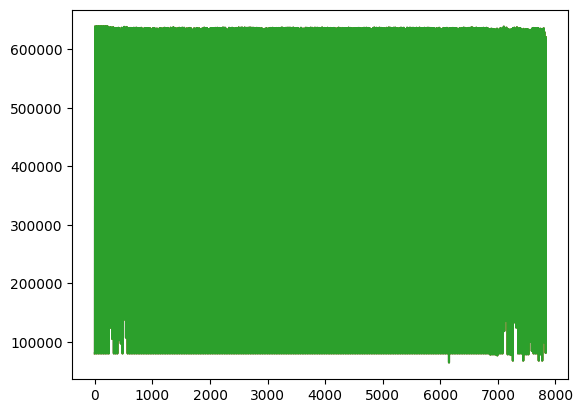

In [65]:
y, x = O.shape[:2]
print(f"y: {y}, x: {x}")
#Read each line of image until the whole line value = white, then remove all lines with that value and all prior
def horizontal_projection(line_pixels):
    return np.sum(line_pixels, axis=1) # Do the same but for other axis when segmenting graphs

tmp = horizontal_projection (O[6737:14570])

plt.plot(tmp)


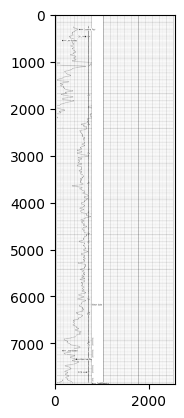

In [63]:
plt.imshow(O[6700:14570])

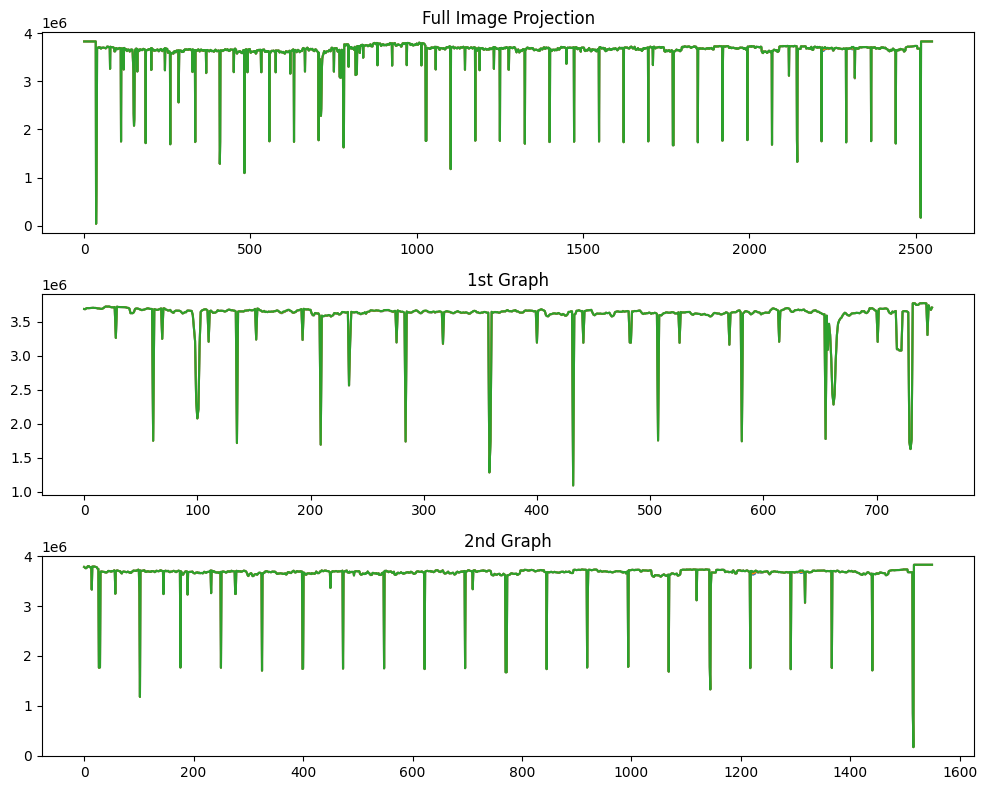

In [98]:
# Looking at the other axis to recognize the different graphs

# Save the interval without the headers
headerless_O = O[6700:14570]

def horizontal_projection(line_pixels):
    return np.sum(line_pixels, axis=0)

tmp = horizontal_projection(O)

#plt.plot(tmp)

O_graph1 = horizontal_projection(O[:, 50:800]) 
#plt.plot(O_graph1_x)

O_graph2 = horizontal_projection(O[:, 1000:]) 

# Create three separate subplots
plt.figure(figsize=(10, 8))  # Optional: specify figure size

# First subplot
plt.subplot(3, 1, 1)
plt.plot(tmp)
plt.title('Full Image Projection')

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(O_graph1)
plt.title('1st Graph')

# Thirs subplot
plt.subplot(3, 1, 3)
plt.plot(O_graph2)
plt.title('2nd Graph')

# Add some spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()